2025-05-29 17:46:50.740723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748540811.047919      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748540811.123914      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train Data: (26938, 5), Validation Data: (8980, 5), Test Data: (8980, 5)


I0000 00:00:1748540832.600444      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 116s 255ms/step - accuracy: 0.8967 - loss: 0.2318 - val_accuracy: 0.9801 - val_loss: 0.0661
Epoch 2/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 107s 255ms/step - accuracy: 0.9866 - loss: 0.0451 - val_accuracy: 0.9806 - val_loss: 0.0654
Epoch 3/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 107s 253ms/step - accuracy: 0.9929 - loss: 0.0219 - val_accuracy: 0.9817 - val_loss: 0.0602
Epoch 4/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 106s 252ms/step - accuracy: 0.9926 - loss: 0.0216 - val_accuracy: 0.9829 - val_loss: 0.0570
Epoch 5/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 106s 252ms/step - accuracy: 0.9962 - loss: 0.0121 - val_accuracy: 0.9772 - val_loss: 0.0822
Epoch 6/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 106s 253ms/step - accuracy: 0.9974 - loss: 0.0084 - val_accuracy: 0.9810 - val_loss: 0.0706
Epoch 7/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 106s 252ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accuracy: 0.9788 - val_loss: 0.0789


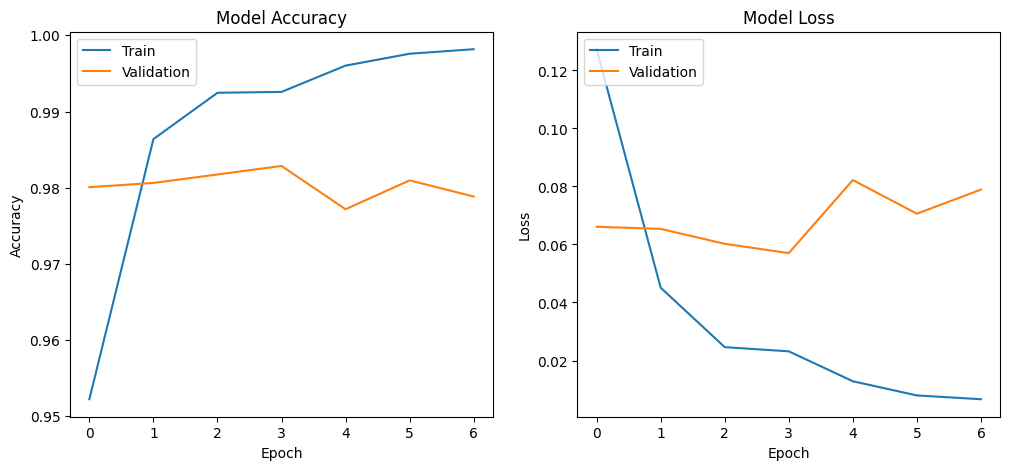

281/281 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step
Accuracy: 98.47%
Precision: 0.9888
Recall: 0.9819
F1 Score: 0.9854

Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.98      4284
        Fake       0.99      0.98      0.99      4696

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



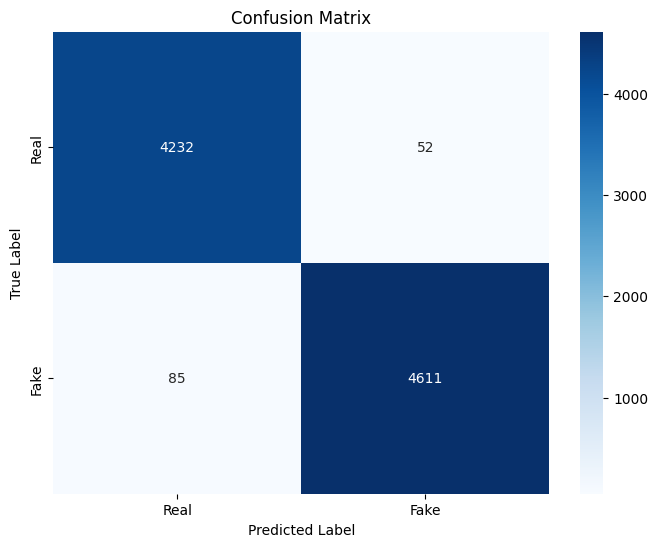

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import lime
import lime.lime_text
import shap


negative_df = pd.read_csv("/kaggle/input/fake-news-detection/true.csv")
negative_df["fake"] = 0  
positive_df = pd.read_csv("/kaggle/input/fake-news-detection/fake.csv")
positive_df["fake"] = 1  

train_df = pd.concat([negative_df, positive_df]).sample(frac=1, random_state=42)  

train_data, temp_data = train_test_split(train_df, test_size=0.4, stratify=train_df["fake"], random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data["fake"], random_state=42)


print(f"Train Data: {train_data.shape}, Validation Data: {valid_data.shape}, Test Data: {test_data.shape}")


def create_dataset(dataframe, shuffle=True, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["text"].values, dataframe["fake"].values))
    if shuffle:
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return dataset


train_ds = create_dataset(train_data)
valid_ds = create_dataset(valid_data, shuffle=False)
test_ds = create_dataset(test_data, shuffle=False)


max_words = 10000  
max_sequence_length = 100  

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["text"])

def tokenize_data(dataframe):
    sequences = tokenizer.texts_to_sequences(dataframe["text"])
    return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length)


X_train_pad = tokenize_data(train_data)
X_valid_pad = tokenize_data(valid_data)
X_test_pad = tokenize_data(test_data)
y_train = train_data["fake"].values
y_valid = valid_data["fake"].values
y_test = test_data["fake"].values


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=128),
    tf.keras.layers.SpatialDropout1D(0.2),  
    tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),  
    tf.keras.layers.Dense(1, activation='sigmoid')  
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    X_train_pad, y_train, 
    epochs=20, 
    batch_size=64, 
    validation_data=(X_valid_pad, y_valid),
    callbacks=[early_stopping]
)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


y_pred = model.predict(X_test_pad)
y_pred_binary = (y_pred > 0.5).astype(int) 


accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y_test, y_pred_binary)
accuracy_value = accuracy.result().numpy()

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f'Accuracy: {accuracy_value * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_binary, target_names=["Real", "Fake"]))


cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

===== EXPLAINING A REAL NEWS ARTICLE =====
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Model prediction: Real news (probability: 0.0004)

Explanation (words contributing to the prediction):
• "paragraph": 0.0544 points toward REAL
• "the": 0.0478 points toward FAKE
• "Agency": 0.0440 points toward REAL
• "News": 0.0371 points toward FAKE
• "video": 0.0363 points toward FAKE
• "Reuters": 0.0344 points toward REAL
• "dropped": 0.0267 points toward REAL
• "staff": 0.0208 points toward REAL
• "independently": 0.0204 points toward REAL
• "coverage": 0.0176 points toward REAL


<Figure size 1000x600 with 0 Axes>

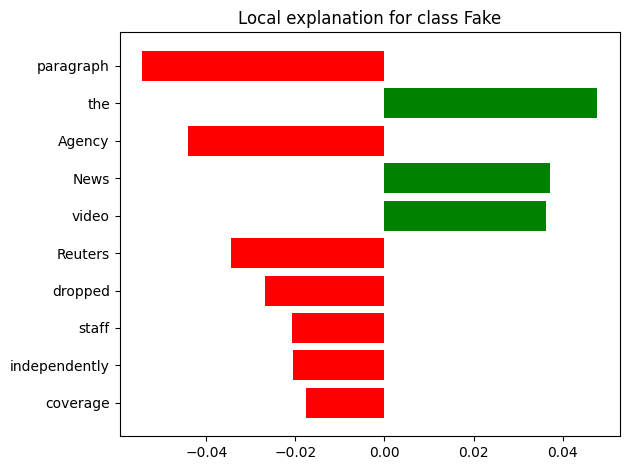


===== EXPLAINING A FAKE NEWS ARTICLE =====
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Model prediction: Fake news (probability: 0.9996)

Explanation (words contributing to the prediction):
• "Via": 0.3879 points toward FAKE
• "t": 0.1086 points toward FAKE
• "the": 0.0990 points toward FAKE
• "movement": 0.0717 points toward REAL
• "said": 0.0708 points toward REAL
• "observers": 0.0648 points toward REAL
• "fist": 0.0625 points toward FAKE
• "h": 0.0449 points toward FAKE
• "women": 0.0416 points toward FAKE
• "or": 0.0373 points toward FAKE


<Figure size 1000x600 with 0 Axes>

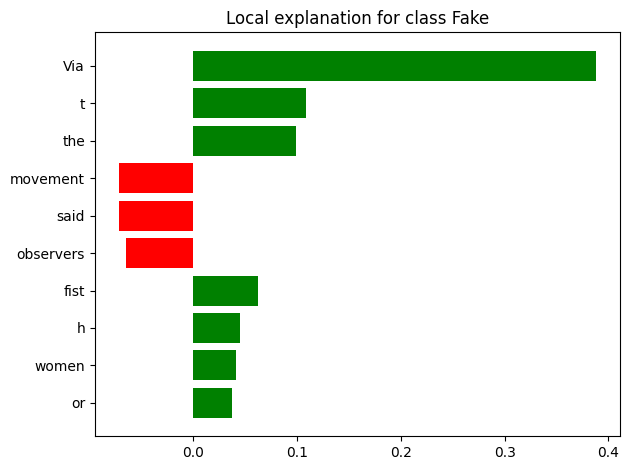

In [2]:

class LSTMWrapper:
    def __init__(self, model, tokenizer, max_sequence_length):
        self.model = model
        self.tokenizer = tokenizer
        self.max_sequence_length = max_sequence_length
        
    def predict_proba(self, texts):
        
        if isinstance(texts, str):
            texts = [texts]
            
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=self.max_sequence_length)
        predictions = self.model.predict(padded)
        
        
        return np.hstack([1-predictions, predictions])


wrapper = LSTMWrapper(model, tokenizer, max_sequence_length)


explainer = lime.lime_text.LimeTextExplainer(class_names=['Real', 'Fake'])


def explain_with_lime(text_to_explain, num_features=10):
    explanation = explainer.explain_instance(
        text_to_explain, 
        wrapper.predict_proba, 
        num_features=num_features
    )
    
    
    prob = wrapper.predict_proba([text_to_explain])[0, 1]
    pred_class = "Fake" if prob > 0.5 else "Real"
    
    print(f"Model prediction: {pred_class} news (probability: {prob:.4f})")
    print("\nExplanation (words contributing to the prediction):")
    
    
    for feature, weight in explanation.as_list():
        direction = "FAKE" if weight > 0 else "REAL"
        print(f"• \"{feature}\": {abs(weight):.4f} points toward {direction}")
    
    
    plt.figure(figsize=(10, 6))
    explanation.as_pyplot_figure()
    plt.tight_layout()
    plt.show()
    
    return explanation


real_news_example = test_data[test_data['fake'] == 0]['text'].iloc[5]
fake_news_example = test_data[test_data['fake'] == 1]['text'].iloc[5]

print("===== EXPLAINING A REAL NEWS ARTICLE =====")
real_explanation = explain_with_lime(real_news_example)

print("\n===== EXPLAINING A FAKE NEWS ARTICLE =====")
fake_explanation = explain_with_lime(fake_news_example)


Initializing SHAP explainer (this may take a while)...
Computing SHAP values for 5 examples...
309/309 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step
309/309 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step


PermutationExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

311/311 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step
311/311 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step


PermutationExplainer explainer:  60%|██████    | 3/5 [01:12<00:38, 19.19s/it]

311/311 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step
311/311 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step


PermutationExplainer explainer:  80%|████████  | 4/5 [01:51<00:27, 27.32s/it]

312/312 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step
312/312 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step


PermutationExplainer explainer: 100%|██████████| 5/5 [02:29<00:00, 31.47s/it]

311/311 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step
311/311 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step


PermutationExplainer explainer: 6it [03:09, 37.81s/it]                       


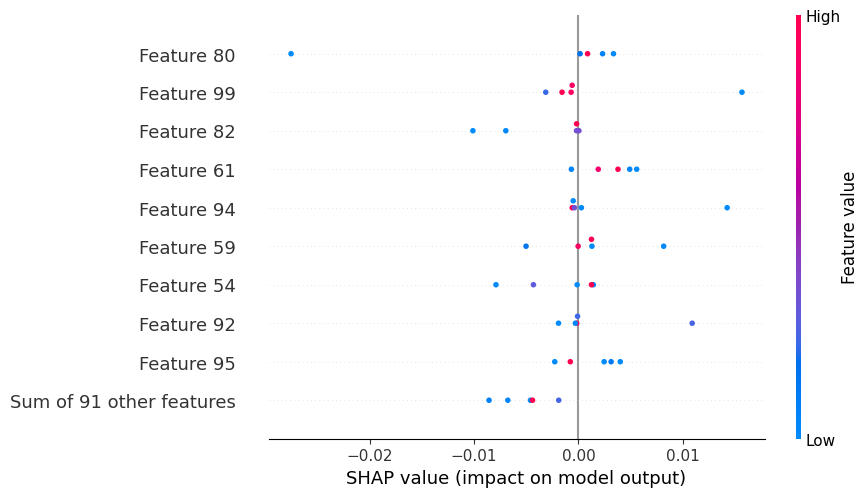

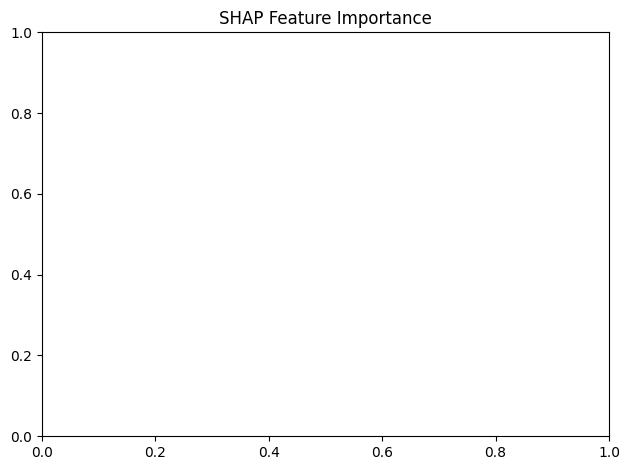


Detailed SHAP explanation for Fake news example:


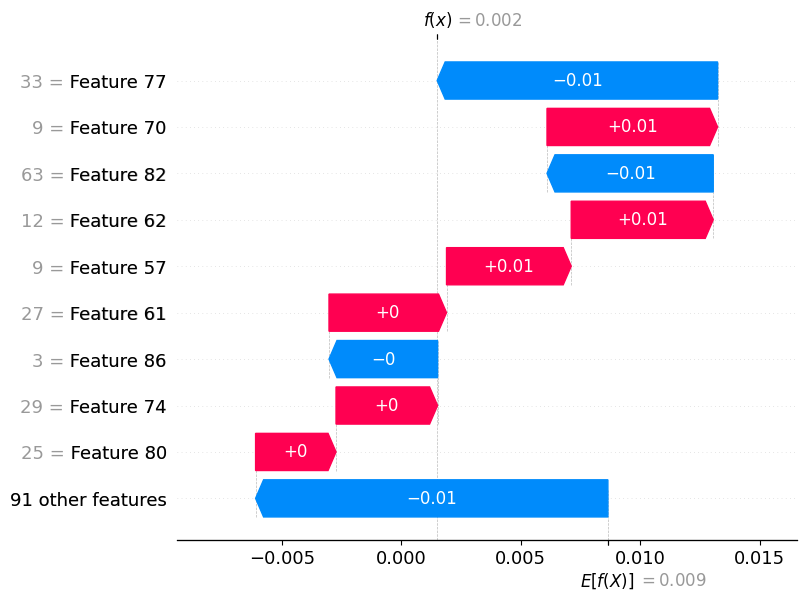

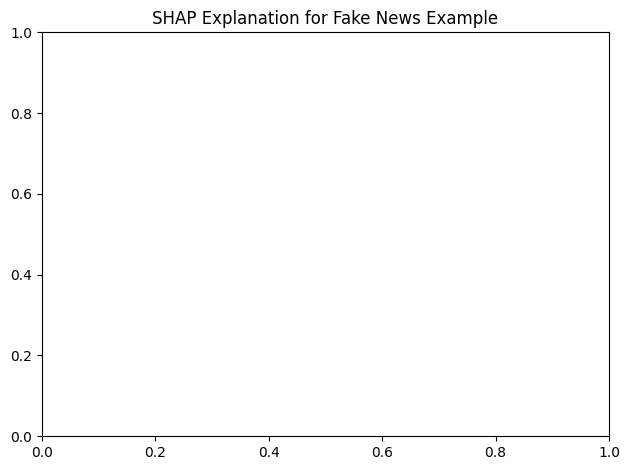


Model and interpretability analysis completed!


In [3]:


def text_to_input(texts):
    if isinstance(texts, np.ndarray):  
        texts = texts.tolist()
    elif isinstance(texts, str):
        texts = [texts]

    
    texts = [str(text) for text in texts]  
    
    sequences = tokenizer.texts_to_sequences(texts)
    return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length)

def model_predict(texts):
    inputs = text_to_input(texts)
    return model.predict(inputs).flatten()


background_size = 50
background_indices = np.random.choice(len(test_data), background_size, replace=False)
background_texts = test_data['text'].iloc[background_indices].tolist()
background_inputs = text_to_input(background_texts)  


print("\nInitializing SHAP explainer (this may take a while)...")
explainer = shap.Explainer(model_predict, background_inputs)


n_examples = 5
sample_indices = np.random.choice(len(test_data), n_examples, replace=False)
sample_texts = test_data['text'].iloc[sample_indices].tolist()
sample_inputs = text_to_input(sample_texts)  
sample_labels = test_data['fake'].iloc[sample_indices].tolist()

print(f"Computing SHAP values for {n_examples} examples...")
shap_values = explainer(sample_inputs)


plt.figure(figsize=(12, 8))
shap.plots.beeswarm(shap_values)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()


example_idx = 0
print(f"\nDetailed SHAP explanation for {'Fake' if sample_labels[example_idx] == 1 else 'Real'} news example:")
plt.figure(figsize=(12, 8))
shap.plots.waterfall(shap_values[example_idx])
plt.title(f"SHAP Explanation for {'Fake' if sample_labels[example_idx] == 1 else 'Real'} News Example")
plt.tight_layout()
plt.show()


model.save('lstm_fake_news_model.h5')
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\nModel and interpretability analysis completed!")


In [4]:

y_pred_binary = y_pred_binary.flatten()
y_test = y_test.flatten()


misclassified_df = pd.DataFrame({
    'Text Snippet': test_data['text'].values,
    'True Label': ['Fake' if label == 1 else 'Real' for label in y_test],
    'Predicted Label': ['Fake' if pred == 1 else 'Real' for pred in y_pred_binary]
})


misclassified_df = misclassified_df[misclassified_df['True Label'] != misclassified_df['Predicted Label']]


misclassified_df["Comment"] = ""


print(misclassified_df.head(5))




                                          Text Snippet True Label  \
162  The Wall Street Journal reported on Friday tha...       Fake   
241  HANOI (Reuters) - U.S. President Donald Trump ...       Real   
281  BANGKOK (Reuters) - Thailand officially ended ...       Real   
380  Ask your liberal friends to tell you more abou...       Fake   
503  In June of 2016 over 10,000 migrants came to I...       Fake   

    Predicted Label Comment  
162            Real          
241            Fake          
281            Fake          
380            Real          
503            Real          
